In [13]:
import numpy as np
from bsread import source, Source
from scipy.interpolate import interp1d
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import convolve1d
from datetime import datetime
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
ROI_background = 'SARES11-SPEC125-M2.roi_background_x_profile'
ROI_signal = 'SARES11-SPEC125-M2.roi_signal_x_profile'
ROI_signal_baby = 'SARES11-SPEC125-M1.roi_signal_x_profile'
Events = 'SAR-CVME-TIFALL4:EvtSet'
IZero = 'SAROP11-PBPS117:INTENSITY'
Channels = [ROI_background, ROI_signal, Events, IZero]
Channels_baby = [ROI_signal_baby, Events, IZero]
# shutter = PV('SARFE10-OPSH059:REQUEST')
pixelNum = np.arange(0,2048)
derivFilter = np.concatenate((signal.tukey(2000)[0:500], np.ones(2048-1000), signal.tukey(2000)[1500:2000]))

# spectrometer wavelength calibration / frequency conversion
# M2
lambdas = 467.55 + 0.07219*np.arange(0,2047) # calibration from 23-9-2020
nus = 299792458 / (lambdas * 10**-9) # frequency space, uneven
nus_new = np.linspace(nus[0], nus[-1], num=2047, endpoint=True) # frequency space, even
# M1
lambdas_baby = 528.34 + 0.0261*np.arange(0,2048) # calibration from 06-10-2021 on the small kymera 
nus_baby = 299792458 / (lambdas_baby * 10**-9) # frequency space, uneven, baby
nus_new_baby = np.linspace(nus_baby[0], nus_baby[-1], num=2048, endpoint=True) # frequency space, even, baby

In [4]:
# functions for M2

def measure(nshots, chans):

    pulse_ids = np.empty(nshots)
    events = np.empty((nshots, 256))
    backgrounds = np.empty((nshots, 2047))
    signals = np.empty((nshots, 2047))
#    signals_baby = np.empty((nshots, 2047))
    iZeros = np.empty(nshots)
    
    stream = Source(channels=chans)
    stream.connect()

    ntotal = 0
    i = 0
    while i < nshots:
        ntotal += 1
        try:
            message = stream.receive()
        except Exception as e:
            print(type(e).__name__, e)
            while True:
                try:
                    stream = Source(channels=chans)
                    stream.connect()
                except Exception as e2:
                    print(type(e2).__name__, e2)
                else:
                    break

        data = message.data.data

        sig =  data[ROI_signal].value
#        sig_baby = data[ROI_signal_baby].value
        back = data[ROI_background].value
        i0 = data[IZero].value
        evs = data[Events].value
        if (sig is None) or (back is None) or (evs is None) or (i0 is None):
            continue
        pulse_ids[i] = message.data.pulse_id
        events[i] = evs
        backgrounds[i] = back
        signals[i] = sig
#        signals_baby[i] = sig_baby
        iZeros[i] = i0
        i += 1
            
    stream.disconnect()

    timeofdata = datetime.now()
    print('Good shots: {} out of a total {} requested'.format(nshots, ntotal))
#    print(f'Good shots: {ngood} out of a total {ntotal} requested')

    return pulse_ids, events, backgrounds, signals, iZeros

filters = {
    "YAG": np.concatenate((np.ones(50),signal.tukey(40)[20:40], np.zeros(1977), np.zeros(2047))), # fourier filter for YAGS
    "SiN": np.concatenate((signal.tukey(40)[20:40], np.zeros(2027), np.zeros(2047))), # fourier filter for 5um SiN
    "SiN2": np.concatenate((signal.tukey(32)[16:32], np.zeros(2031), np.zeros(2047))), # fourier filter for 2um SiN
    "babyYAG": np.concatenate((signal.tukey(40)[20:40], np.zeros(2028), np.zeros(2048))), # baby timetool YAG filter
    "babyYAG2": np.concatenate((np.ones(50),signal.tukey(40)[20:40], np.zeros(1978), np.zeros(2048))) # baby timetool YAG
}

Heaviside = np.concatenate((np.zeros(100), np.ones(100)))

def edge(filter_name, backgrounds, signals, background_from_fit, peakback):
    """
    returns:
    edge positions determined from argmax of peak traces
    signal traces, should show a change in transmission near px 1024 if set up correctly
    peak traces, which are the derivative of signal traces
    """

    ffilter = filters[filter_name]
    # background subtraction
    sig2 = np.nan_to_num(signals / backgrounds) / background_from_fit
    # interpolate to get evenly sampled in frequency space
    sig3inter = interp1d(nus, sig2, kind='cubic')
    sig3 = sig3inter(nus_new)
    sig4 = np.hstack((sig3, np.zeros_like(sig3)))
    # Fourier transform, filter, inverse fourier transform, take the real part, take the derivative (sig5gaussO1)
    sig4fft = np.fft.fft(sig4)
    sig4filtered = sig4fft * ffilter
    sig4inverse = np.fft.ifft(sig4filtered)
    sig4invreal = 2 * np.real(sig4inverse)
    sig4inter = interp1d(nus_new, sig4invreal[..., 0:2047], kind='cubic')
    sig5 = sig4inter(nus)
    
    # transmissive edges, not used, just for plotting if you like.
    sig5gaussO0 = gaussian_filter1d(sig5, 30)
    sig6 = convolve1d(sig5gaussO0, Heaviside)
    # peaks
    sig5gaussO1 = gaussian_filter1d(sig5, 50, order = 1) - peakback
    peak2 = np.argmax(sig5gaussO1, axis = -1)
    
    return peak2, sig6, sig5gaussO1

def goodshots(events, *arrays):
    fel = events[:, 13]
    laser = events[:, 18]
    darkShot = events[:, 21]
    pulsePicker = events[:, 200]
    good_shots = np.logical_and.reduce((fel, laser, np.logical_not(darkShot), pulsePicker))
    return [a[good_shots] for a in arrays]

def backgroundshots(events, *arrays):
    pulsePicker = events[:, 200]
    laser = events[:, 18]
    darkShot = events[:, 21]
    background_shots = np.logical_and.reduce((laser, np.logical_not(darkShot), np.logical_not(pulsePicker)))
    return [a[background_shots] for a in arrays]

def lasershots(events, *arrays):
    fel = events[:, 13]
    laser = events[:, 18]
    darkShot = events[:, 21]
    laser_shots = np.logical_and.reduce((laser, np.logical_not(darkShot)))
    return [a[laser_shots] for a in arrays]

def polyfxn(x, a, b, c, d, e, f, g, h):
    return a*x**7 + b*x**6 + c*x**5 + d*x**4 + e*x**3 + f*x**2 + g*x + h

def background(filter_name):
    # measure w/o FEL
    shutter.put(0)
    _, events, backgrounds, signals, _ = measure(100, Channels)
    shutter.put(1)

    offset_background, offset_signal = np.mean(lasershots(events, backgrounds, signals), axis=1)
    background_avg = offset_signal/offset_background

    fitBackground, _ = optimize.curve_fit(polyfxn, lambdas, background_avg, p0=[1, 1, 1, 1, 1, 1, 1 ,1])
#    fitBackground_baby, _ = optimize.curve_fit(polyfxn, lambdas_baby, background_avg_baby, p0=[1, 1, 1, 1, 1, 1, 1 ,1]) 
    background_from_fit = polyfxn(lambdas, *fitBackground)
#    background_from_fit_baby = polyfxn(lambdas_baby, *fitBackground_baby)

    _, _, peakback = edge(filter_name, background_from_fit, background_avg, 1, 0)
#    _, _, peakback_baby = edge(filter_name, background_from_fit_baby, background_avg_baby, 1, 0)

    plt.ion()
    plt.figure(figsize=(8,8))
    plt.subplot(311)
    plt.plot(offset_signal, label = 'sig')
    plt.plot(offset_background, label = 'bkg')
    plt.legend(loc='best')
    plt.xlim(0,2047)

    plt.subplot(312)
    plt.plot(background_avg, label='raw')
    plt.plot(background_from_fit, label='fit')
    plt.plot(background_avg/background_from_fit, label='corrected')
#    plt.plot(background_avg_baby, label='baby')
#    plt.plot(background_from_fit_baby, label='fit baby')
#    plt.plot(background_avg_baby/background_from_fit_baby, label='corrected baby')
    plt.xlabel('pixel')
    plt.legend(loc='best')
    plt.xlim(0,2047)
    plt.ylim(0.5, 2.5)
    plt.grid()

    plt.subplot(313)
    plt.plot(peakback*10000, color='black', label='peak background')
    plt.legend(loc='best')
    plt.xlim(0,2047)
    plt.ylim(-10, 10)
    plt.show()

    return background_from_fit, peakback


In [5]:
nshots = 100

In [6]:
pulse_ids, events, backgrounds, signals, iZeros = measure(nshots, Channels)

Good shots: 100 out of a total 113 requested


In [9]:
backgrounds

array([[ 62393.,  61528.,  61462., ..., 125936., 126138., 125577.],
       [ 61604.,  60666.,  60757., ..., 122696., 123720., 122520.],
       [ 62077.,  62061.,  62002., ..., 125179., 126663., 126038.],
       ...,
       [ 61640.,  60550.,  61297., ..., 126506., 126477., 126138.],
       [ 60438.,  59037.,  59878., ..., 123484., 124063., 122913.],
       [ 62014.,  60588.,  61099., ..., 126060., 126806., 125672.]])

<IPython.core.display.Javascript object>


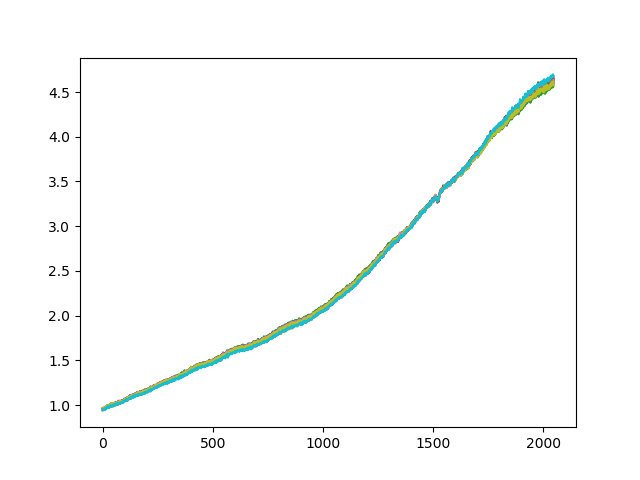

In [14]:
plt.figure()
for i in range(0,10):
    plt.plot(signals[i,:]/backgrounds.mean(axis=0))